# Exercise 4 - Python: Neural Networks Learning

## *Part One*: Neural Networks

Recognizing handwritten digits.  Though the source is not explicitly mentioned, it is just like the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database).

Each value of $X$ will be a 20x20 grid of values representing the grayscale intensity at that location "unrolled" into a 400-dimensional vector.  Here is an example for the first number in our data, $X^{(1)}$:

$\hspace{1cm} X^{(1)} = \begin{bmatrix}x_{(1, 1)}^{(1)},\ x_{(1, 2)}^{(1)},\ \dots\ x_{(1, 20)}^{(1)} \\
                                    x_{(2, 1)}^{(1)},\ x_{(2, 2)}^{(1)},\ \dots\ x_{(2, 20)}^{(1)} \\
                                    \vdots \\ 
                                    x_{(20, 1)}^{(1)},\ x_{(20, 2)}^{(1)},\ \dots\ x_{(20, 20)}^{(1)} \\ 
                    \end{bmatrix}
\rightarrow \begin{bmatrix} x_1^{(1)},\ x_2^{(1)},\ \dots\ x_{400}^{(1)} \end{bmatrix}
\rightarrow (x^{(1)})^T$

Here is our collection of all of the numbers for $X$:

$\hspace{1cm} X = \begin{bmatrix} (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(400)})^T \end{bmatrix}$

---

Beginning with package imports, data loading, and initial visualization

In [1]:
import numpy as np
import pandas as pd
from math import floor, ceil  # Used in calculating subplot parameters
from scipy import optimize  # Discovering optimal parameters
from sklearn.preprocessing import OneHotEncoder  # Feature transformation
import matplotlib.pyplot as plt
import seaborn as sns

# For comparing answers
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import scipy.io as sio # Used to load the Octave/MATLAB *.mat files

plt.style.use('ggplot')

%matplotlib inline

In [131]:
# Loading in the data from the .mat files
data = sio.loadmat('ex4/ex4data1.mat')
X, y = data['X'], data['y']

# Replacing where 0 is marked as 10 in y
y = np.where(y == 10,  # Condition for replacement
             0,  # Replacement
             y)  # Keeps other digits the same

# Flattening y from an array of arrays into one vector
y = y.flatten()

print(X.shape)
X

(5000, 400)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

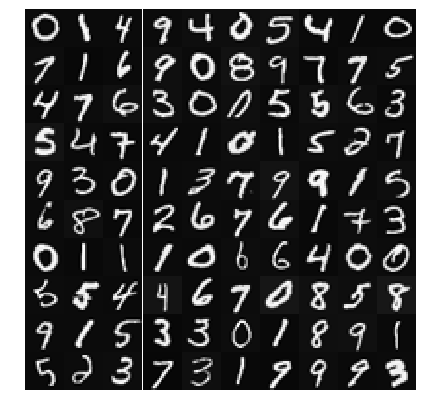

In [7]:
# Randomly sampling 100 numbers to display
random100 = X[np.random.randint(X.shape[0], size=100), :]  # 1: excludes the intercept

def plot_digits(digits, width=8, height=8):
    """Plots a grid of the supplied digits"""
    # Creating the overall figure to fill with plots of the numbers
    fig = plt.figure(figsize=(width, height))
    
    # Calculates the number of columns/rows for the subplot grid
    figShape = np.sqrt(digits.shape[0])

    # Loop over numbers to plot into the overall figure
    for i, number in enumerate(digits):  # Enumerating to include index
        number = number.reshape(20, 20).T  # Reshape X into 20x20 array
        ax = fig.add_subplot(floor(figShape),  # Rows
                             ceil(figShape),  # Columns
                             i+1)  # Positioning
        plt.imshow(number, cmap='gray')  # Plotting the number
    
        # Removing unnecessary components for aesthetics
        plt.grid(False)
        plt.axis('off')
        fig.subplots_adjust(wspace=0, hspace=0)
    
    plt.show()
    
plot_digits(digits=random100, width=7, height=7)

### Feedforward and Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K \big[-y_k^{(i)}log((h_\theta(x^{(i)}))_k) - (1-y_k^{(i)}) log(1-(h_\theta(x^{(i)}))_k) \big] + \\
\hspace{1.2cm} \frac{\lambda}{2m} \big[\sum_{j=1}^{25} \sum_{k=1}^{400} (\theta_{j, k}^{(1)})^2 +
\sum_{j=1}^{10} \sum_{k=1}^{25} (\theta_{j, k}^{(2)})^2 \big]$

Note: $h_\theta(x^{(i)})_k = a^{(3)}_k$, or the activation of the $k$-th output unit

#### Regularization Parameter

$+ \frac{\lambda}{2m} \big[\sum_{j=1}^{25} \sum_{k=1}^{400} (\theta_{j, k}^{(1)})^2 +
\sum_{j=1}^{10} \sum_{k=1}^{25} (\theta_{j, k}^{(2)})^2 \big]$



The exercise states that the unregularized cost function should be around 0.287629, and the regularized cost function with $\lambda = 1$ should be around 0.383770

In [329]:
# Importing weights provided by the exercise
weights = sio.loadmat('ex4/ex4weights.mat')

theta1, theta2 = weights['Theta1'], weights['Theta2']

def sigmoid(z):
    """Calculates the sigmoid function for use as the activation function in the neural network"""
    z = 1/(1+np.exp(-z))
    return z

def neural_network_prediction(thetas, X, y, C=0):
    """
    Takes pre-determined thetas as input, and returns predictions and cost
    Assumes the bias term is not included in the input
    """
    
    # Setting variables used in the function
    m = y.size
    K = len(np.unique(y))
    h = X.copy()  # Hypothesis to be modified in the neural network
   
    # Feed-forward propagation
    for theta in thetas:
        h = np.insert(h, 0, 1, axis=1)  # Adding the bias term
        h = h.dot(theta.T)  # Multiplying by the weights
        h = sigmoid(h)  # Activation function
    
    # Moves the class probabilities for digit 0 to the 0th index
    h = np.roll(h, 1)
    
    # Returns index with the highest value
    prediction = np.argmax(h, axis=1)
    
    # One hot encoding y into binary arrays for the cost function
    y = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()
    
    error = np.sum(-y * np.log(h) - (1-y) * np.log(1-h))
    
    # Removing bias terms from regularization through np.delete()
    regParameter = [np.sum(np.delete(theta, 0, axis=1)**2) for theta in thetas]
    regParameter = (C/(2*m)) * sum(regParameter)
    
    cost = (1/m) * error + regParameter
    
    return prediction, cost

print('Unregularized cost:', neural_network_prediction([theta1, theta2], X, y)[1])
print('Regularized cost:', neural_network_prediction([theta1, theta2], X, y, C=1.0)[1])

Unregularized cost: 0.288828094649
Regularized cost: 0.384968788578


---

##  **Part 2:** Backpropagation

**[Explanation]**

### Sigmoid Gradient

$g'(z) = \frac{d}{dz}g(z) = g(z)(1-g(z))$

where

$sigmoid(z)=g(z)=\frac{1}{1+e^{-z}}$

### Random Initialization

Using the recommended approach of using the number of units in the network:

$\epsilon_{init} =  \frac{\sqrt(6)}{\sqrt{L_{in}+L_{out}}}$

where

$L_{in} = s_l$ and $L_{out} = s_{l+1}$

### Backpropagation

For each output unit $k$ in layer 3 (the output layer), set $\delta^{(3)}_k = (a_k^{(3)} - y_k)$

For the hidden layer $l = 2$, set $\delta^{(2)} = (\theta^{(2)})^T \delta^{(3)} .* g'(z^{(2)})$

### Gradient Checking

For each $i$: $f_i(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2\epsilon}$

---

##  **Part 3:** Visualizing the hidden layer

**[Explanation]**